In [1]:
#Team: Ryomen Itadori
#Members: Daniel Wu, Andrea Zhou
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import numpy as np

In [2]:
'''Dataset Citation:
Samuel, Jim and Khanna, Tanya and Sundar, Srinivasaraghavan, Fear of Artificial Intelligence? NLP, ML and LLMs
based discovery of AI-phobia and fear sentiment propagation by AI news. (March 09, 2024). Available at SSRN: https://ssrn.com/abstract=4755964'''

df = pd.read_csv("https://drive.google.com/uc?export=download&id=1Y4pnUeFz6Nz-TdeMkFfOAmDdHDZvXhqZ")
df.head()

,title,link,date,source,country,language,translated_title,number_of_characters_title,number_of_words_title,day_of_week,...,is_weekend,is_holiday,source_type,final_redirected_URL,domain_of_URL,subdomain_of_URL,URL_depth,top_level_domain,url_length,author
0,Kann künstliche Intelligenz Smalltalk ersetzen...,https://news.google.com/rss/articles/CBMiY2h0d...,2023-11-12,Blick,US,de,Can artificial intelligence replace small talk...,47,8,Sunday,...,True,False,News Outlet,https://www.blick.ch/schweiz/linguistik-profes...,www.blick.ch,www,2,ch,99,[]
1,Lidé se snadněji svěří chatbotům. Emocionální ...,https://news.google.com/rss/articles/CBMidmh0d...,2023-11-12,iDNES.cz,US,cs,People trust chatbots more easily. Emotional A...,72,13,Sunday,...,True,False,Other,https://www.idnes.cz/zpravy/domaci/ai-umela-in...,www.idnes.cz,www,3,cz,118,['Autor']
2,¿Cómo implementar la IA en el comercio online?...,https://news.google.com/rss/articles/CBMicmh0d...,2023-11-12,RRHH Digital,US,es,How to implement AI in online commerce? - Digi...,43,10,Sunday,...,True,False,News Outlet,https://www.rrhhdigital.com/secciones/tecnolog...,www.rrhhdigital.com,www,5,com,114,[]
3,"Kontrolle von KI: Vorsicht, KI! | ZEIT ONLINE ...",https://news.google.com/rss/articles/CBMiXWh0d...,2023-11-12,ZEIT ONLINE English,US,de,"Controlling AI: Be careful, AI! | ZEIT ONLINE ...",56,12,Sunday,...,True,False,Other,https://www.zeit.de/zeit-wissen/2023/06/kuenst...,www.zeit.de,www,4,de,93,[]
4,Los consejos para ganar la lotería de la Intel...,https://news.google.com/rss/articles/CBMiXWh0d...,2023-11-12,C5N,US,es,Tips to win the Artificial Intelligence lotter...,45,9,Sunday,...,True,False,Other,https://www.c5n.com/sociedad/los-consejos-gana...,www.c5n.com,www,2,com,93,[]


In [3]:
dates = ["5/2023","6/2023","7/2023","8/2023","9/2023","10/2023","11/2023"]

#EXPLORATORY DATA ANALYSIS

In [4]:
#BUT FIRST, some preliminary data cleanup
df = df.dropna()

def cleanTitle(title):
  try:
    if "-" in title:
        title = title.split("-")
        title = title[:-1] #gets rid of the - (news network)
        title = " ".join(title)

    if "..." in title:
        title = title.split("...") #gets rid of ...
        title = " ".join(title)

    if "|" in title:
        title = title.split("|")
        title = title[:-1] #gets rid of the | (news network)
        title = " ".join(title)
    return title
  except:
    return title

df['translated_title'] = df['translated_title'].apply(cleanTitle)


<ipython-input-4-2936870333c8>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['translated_title'] = df['translated_title'].apply(cleanTitle)


#1: Show trends of whether title length increases as time goes on

In [5]:
df["monthYear"] = df["month"].astype(str) + "/" + df["year"].astype(str)

df['monthYearDT'] = pd.to_datetime(df['monthYear'])

def recountTitleLength(title):
  return len(title)

df["number_of_characters_title"] = df['translated_title'].apply(recountTitleLength)

grouped_data = df.set_index('monthYearDT').resample('M')['number_of_characters_title'] #See Appendix [1]

y_min = df["number_of_characters_title"].min()
y_max = df["number_of_characters_title"].max()


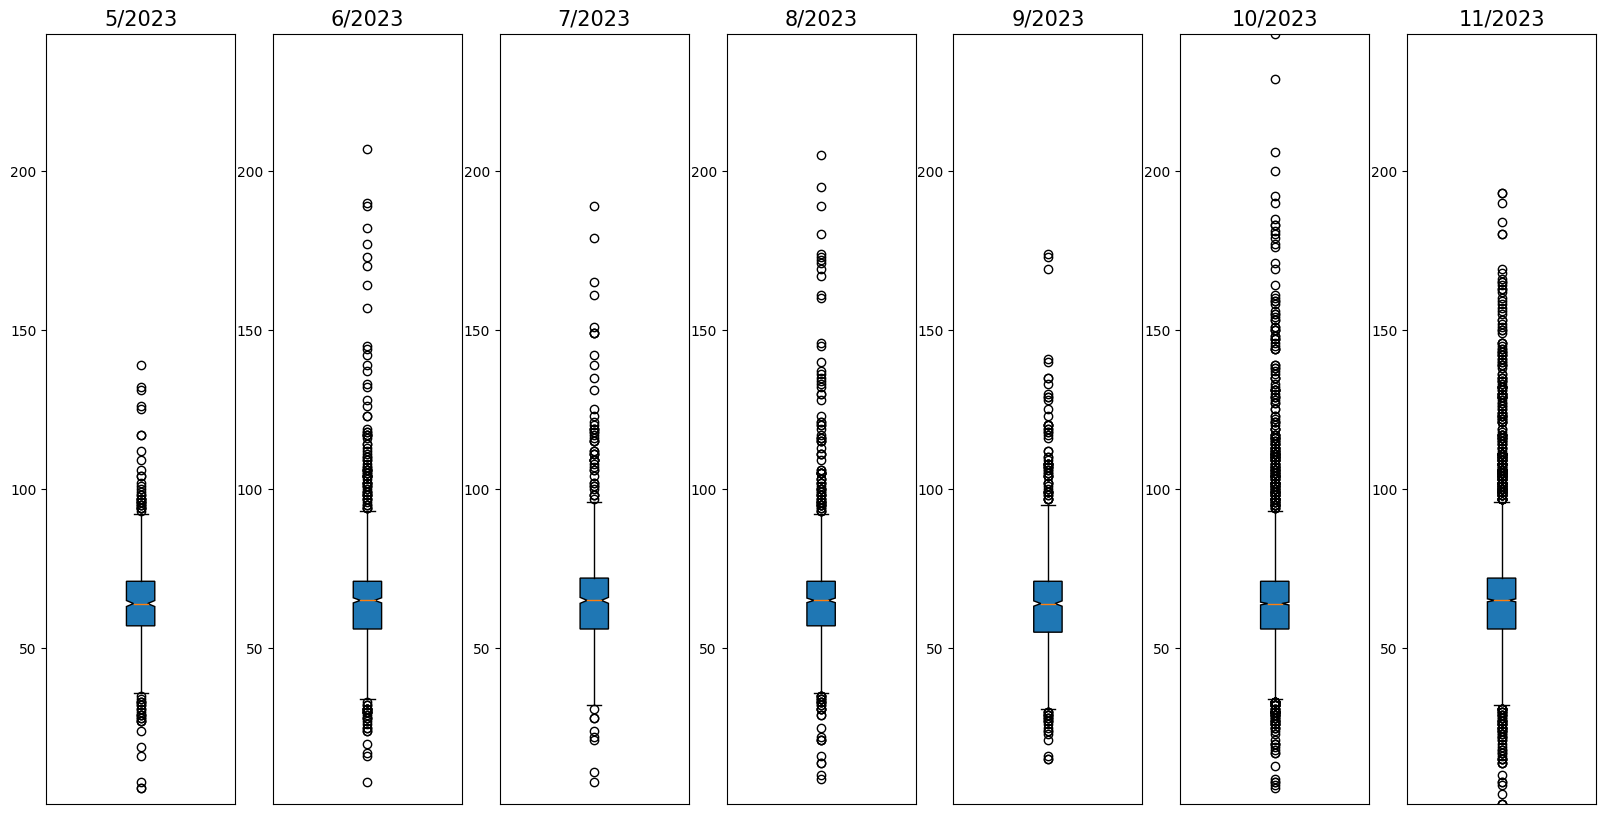

In [6]:

fig, axes = plt.subplots(nrows=1, ncols=len(grouped_data), figsize=(20, 10))
ranges = []
for i, (name, group) in enumerate(grouped_data):
    ax = axes[i]
    box = ax.boxplot(group, notch=True, vert=True, patch_artist=True)
    ax.set_title(dates[i], fontsize = 15)
    ax.set_ylim(y_min, y_max)
    ranges.append(group.max() - group.min())

for ax in axes:
  ax.set_xticks([])

plt.show()

Text(0, 0.5, 'Characters')

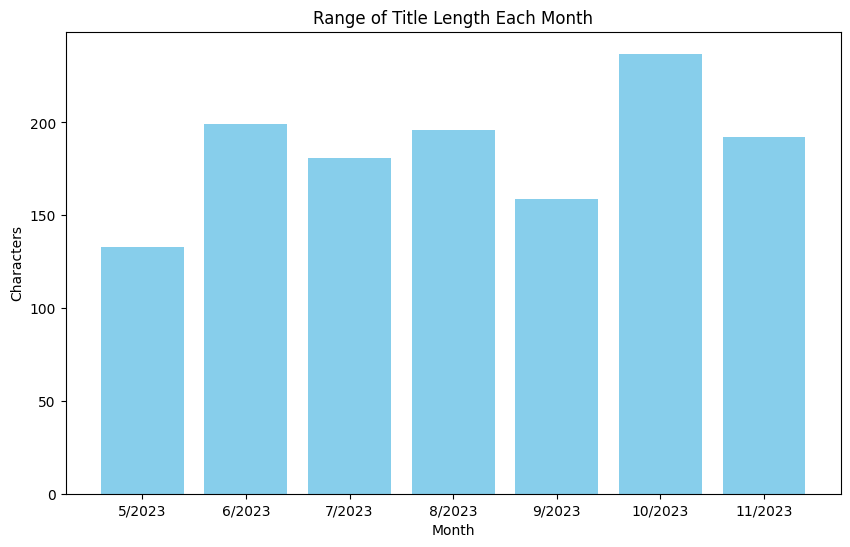

In [7]:

plt.figure(figsize=(10, 6))
plt.bar(dates, ranges, width=0.8, color='skyblue')
plt.title("Range of Title Length Each Month")
plt.xlabel("Month")
plt.ylabel("Characters")


Text(0.5, 0.9, 'p-val: 0.406164223458641')

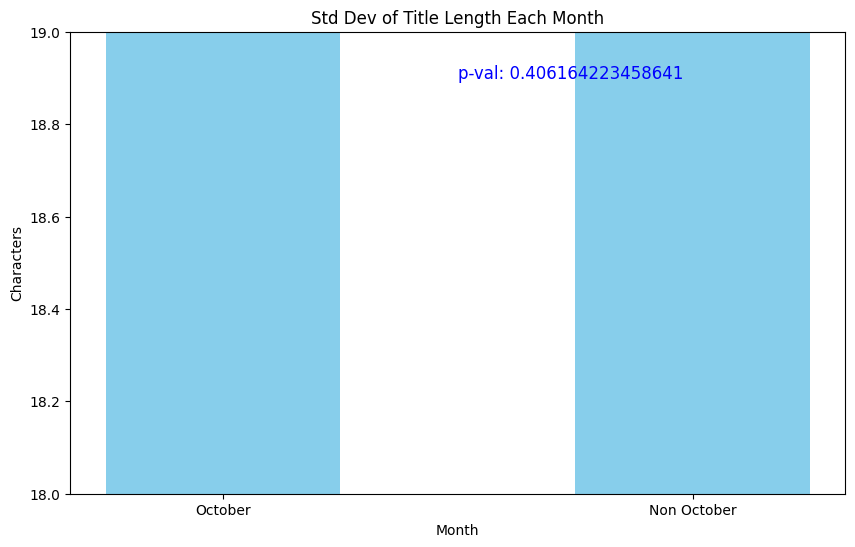

In [8]:

from scipy.stats import bartlett

octData = list(df[df['monthYear'] == "10/2023"]['number_of_characters_title'])
nonOctData = list(df[df['monthYear'] != "10/2023"]['number_of_characters_title'])
stdDevOct = np.std(octData)
stdDevNonOct = np.std(nonOctData)

statistic, p_value = bartlett(octData, nonOctData) #See Appendix [6]

x=['October', 'Non October']
y= [stdDevOct, stdDevNonOct]

plt.figure(figsize=(10, 6))
plt.bar(x, y, width=0.5, color='skyblue')
plt.ylim(18,19)
plt.title("Std Dev of Title Length Each Month")
plt.xlabel("Month")
plt.ylabel("Characters")
plt.text(0.5, 0.9, f"p-val: {p_value}", fontsize=12, color='blue', transform=plt.gca().transAxes) #See Appendix [4]


#2: Sentiment Analysis of titles over time

In [9]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


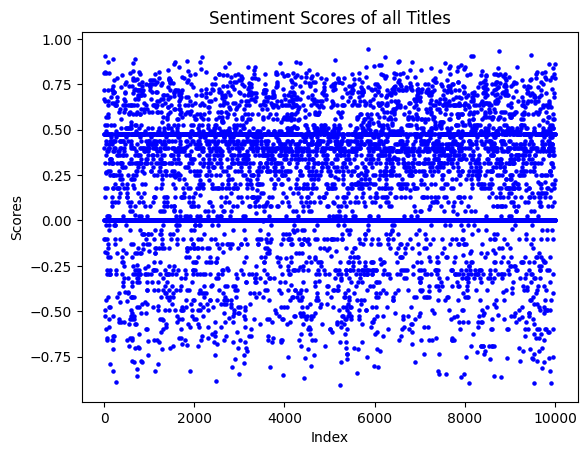

In [10]:
sen = SentimentIntensityAnalyzer()

def getSentScore(string):
  return sen.polarity_scores(string)['compound']

df['title_sent_score'] = df['translated_title'].apply(getSentScore)

sentScoresInOrder = df['title_sent_score'][::-1]

plt.scatter(df.index, sentScoresInOrder, color='blue', label='Column A',s=5)
plt.xlabel('Index')
plt.ylabel('Scores')
plt.title('Sentiment Scores of all Titles')

plt.show()

Text(0.5, 1.0, 'Average Sentiment Score of Each Month')

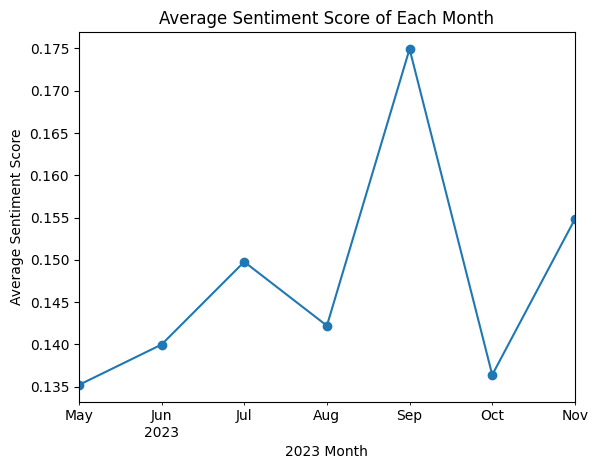

In [11]:


avgSentScores = df.set_index('monthYearDT').resample('M')['title_sent_score'].mean()
avgSentScores.plot(marker= "o")
plt.ylabel("Average Sentiment Score")
plt.xlabel("2023 Month")
plt.title("Average Sentiment Score of Each Month")

#3.) Deeper Dive into 10/2023

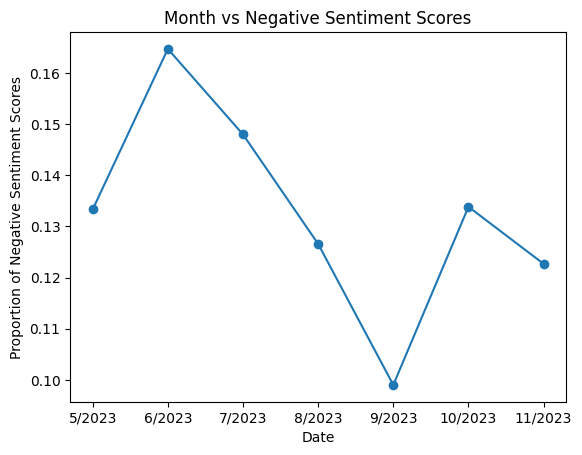

In [12]:
negativeFracs = []
negativeFracs.append( df[(df['monthYear'] == "5/2023") & (df['title_sent_score'] < 0)].shape[0] / df[(df['monthYear'] == "5/2023")].shape[0])
negativeFracs.append(df[(df['monthYear'] == "6/2023") & (df['title_sent_score'] < 0)].shape[0] / df[(df['monthYear'] == "6/2023")].shape[0])
negativeFracs.append( df[(df['monthYear'] == "7/2023") & (df['title_sent_score'] < 0)].shape[0] / df[(df['monthYear'] == "7/2023")].shape[0])
negativeFracs.append( df[(df['monthYear'] == "8/2023") & (df['title_sent_score'] < 0)].shape[0] / df[(df['monthYear'] == "8/2023")].shape[0])
negativeFracs.append( df[(df['monthYear'] == "9/2023") & (df['title_sent_score'] < 0)].shape[0] / df[(df['monthYear'] == "9/2023")].shape[0])
negativeFracs.append( df[(df['monthYear'] == "10/2023") & (df['title_sent_score'] < 0)].shape[0] / df[(df['monthYear'] == "10/2023")].shape[0])
negativeFracs.append( df[(df['monthYear'] == "11/2023") & (df['title_sent_score'] < 0)].shape[0] / df[(df['monthYear'] == "11/2023")].shape[0])
plt.xlabel('Date')
plt.ylabel('Proportion of Negative Sentiment Scores')
plt.title('Month vs Negative Sentiment Scores')
plt.plot(dates,negativeFracs, marker = "o")

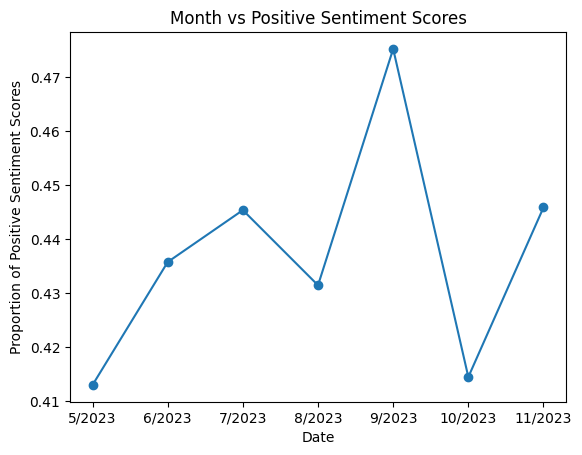

In [13]:
positiveFracs = []
positiveFracs.append( df[(df['monthYear'] == "5/2023") & (df['title_sent_score'] > 0)].shape[0] / df[(df['monthYear'] == "5/2023")].shape[0])
positiveFracs.append(df[(df['monthYear'] == "6/2023") & (df['title_sent_score'] > 0)].shape[0] / df[(df['monthYear'] == "6/2023")].shape[0])
positiveFracs.append( df[(df['monthYear'] == "7/2023") & (df['title_sent_score'] > 0)].shape[0] / df[(df['monthYear'] =="7/2023")].shape[0])
positiveFracs.append( df[(df['monthYear'] == "8/2023") & (df['title_sent_score'] > 0)].shape[0] / df[(df['monthYear'] == "8/2023")].shape[0])
positiveFracs.append( df[(df['monthYear'] == "9/2023") & (df['title_sent_score'] > 0)].shape[0] / df[(df['monthYear'] == "9/2023")].shape[0])
positiveFracs.append( df[(df['monthYear'] == "10/2023") & (df['title_sent_score'] > 0)].shape[0] / df[(df['monthYear'] == "10/2023")].shape[0])
positiveFracs.append( df[(df['monthYear'] == "11/2023") & (df['title_sent_score'] > 0)].shape[0] / df[(df['monthYear'] == "11/2023")].shape[0])
plt.xlabel('Date')
plt.ylabel('Proportion of Positive Sentiment Scores')
plt.title('Month vs Positive Sentiment Scores')
plt.plot(dates,positiveFracs, marker = "o")

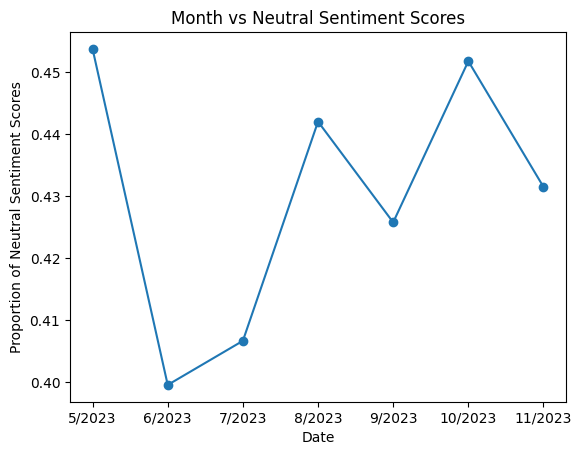

In [14]:
neutralFracs = []
neutralFracs.append( df[(df['monthYear'] == "5/2023") & (df['title_sent_score'] == 0)].shape[0] / df[(df['monthYear'] == "5/2023")].shape[0])
neutralFracs.append( df[(df['monthYear'] == "6/2023") & (df['title_sent_score'] == 0)].shape[0] / df[(df['monthYear'] == "6/2023")].shape[0])
neutralFracs.append( df[(df['monthYear'] == "7/2023") & (df['title_sent_score'] == 0)].shape[0] / df[(df['monthYear'] == "7/2023")].shape[0])
neutralFracs.append( df[(df['monthYear'] == "8/2023") & (df['title_sent_score'] == 0)].shape[0] / df[(df['monthYear'] == "8/2023")].shape[0])
neutralFracs.append( df[(df['monthYear'] == "9/2023") & (df['title_sent_score'] == 0)].shape[0] / df[(df['monthYear'] == "9/2023")].shape[0])
neutralFracs.append( df[(df['monthYear'] == "10/2023") & (df['title_sent_score'] == 0)].shape[0] / df[(df['monthYear'] == "10/2023")].shape[0])
neutralFracs.append( df[(df['monthYear'] == "11/2023") & (df['title_sent_score'] == 0)].shape[0] / df[(df['monthYear'] == "11/2023")].shape[0])
plt.xlabel('Date')
plt.ylabel('Proportion of Neutral Sentiment Scores')
plt.title('Month vs Neutral Sentiment Scores')
plt.plot(dates,neutralFracs, marker = "o")

low overall score, high negative score, low positive score, high neutral score

Text(0.5, 1.0, 'Articles Published on Weekends per Month')

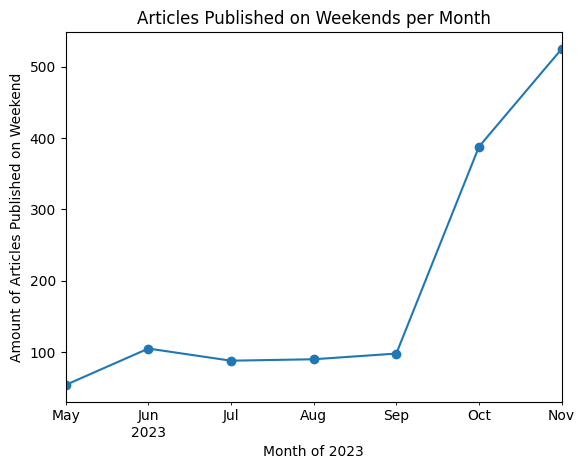

In [15]:
df['is_weekend']= df['is_weekend'].replace({"TRUE": 1, "FALSE": 0})
totPublishedWeekend = df.set_index('monthYearDT').resample('M')['is_weekend'].sum()
totPublishedWeekend.plot(marker = "o")
plt.xlabel("Month of 2023")
plt.ylabel("Amount of Articles Published on Weekend")
plt.title("Articles Published on Weekends per Month")

Text(0.5, 1.0, 'Articles Published on Holidays per Month')

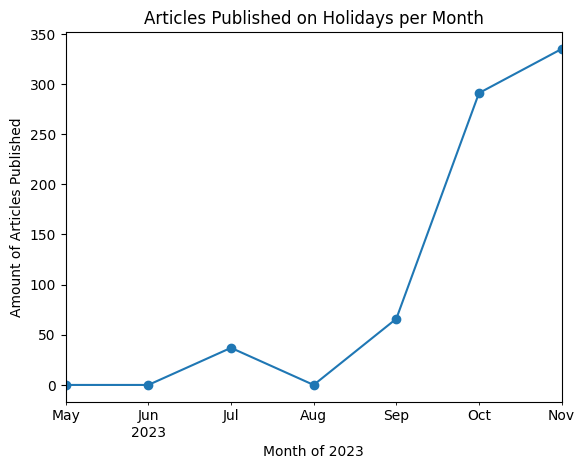

In [16]:
df['is_holiday']= df['is_holiday'].replace({"TRUE": 1, "FALSE": 0})
totPublishedHoliday = df.set_index('monthYearDT').resample('M')['is_holiday'].sum()

totPublishedHoliday.plot(marker = "o")

plt.xlabel("Month of 2023")
plt.ylabel("Amount of Articles Published")
plt.title("Articles Published on Holidays per Month")

Text(0.5, 1.0, 'Articles Published on Holidays per Holiday per Month')

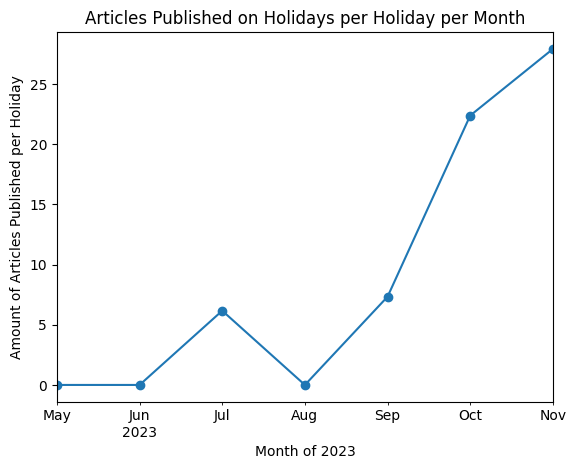

In [17]:
holidayCount = [11,5,6,8,9,13,12] #https://www.holidayinsights.com/everyday.htm
for i in range(len(holidayCount)):
  totPublishedHoliday[i] /= holidayCount[i]

totPublishedHoliday.plot(marker = "o")

plt.xlabel("Month of 2023")
plt.ylabel("Amount of Articles Published per Holiday")
plt.title("Articles Published on Holidays per Holiday per Month")

Text(0, 0.5, 'p-value')

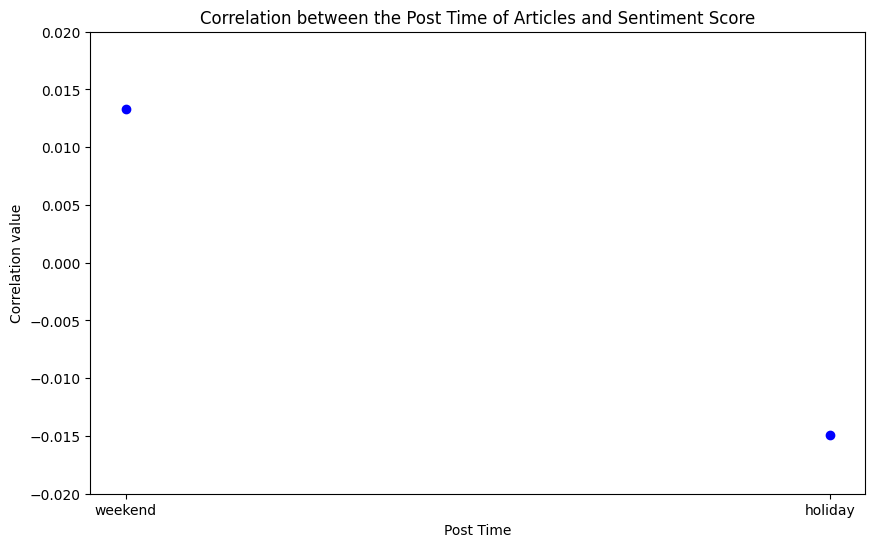

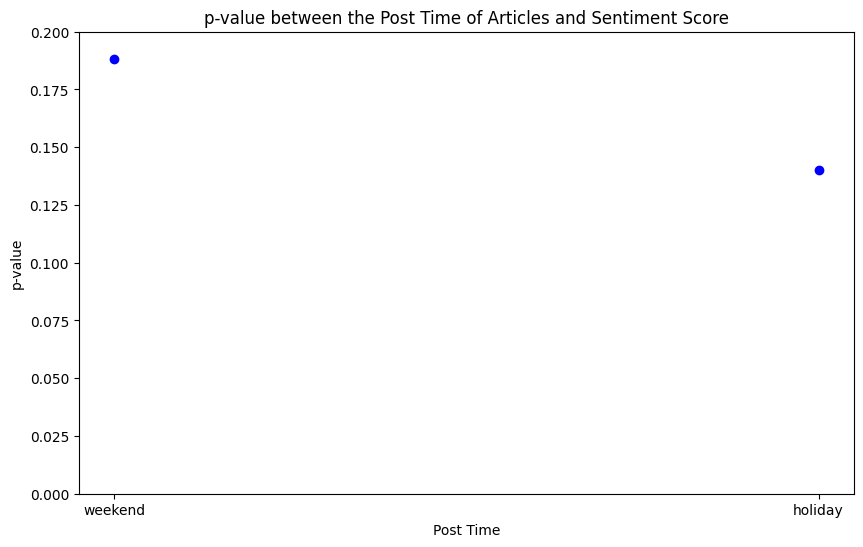

In [18]:
from scipy.stats import pearsonr


corr, p_value = pearsonr(df['is_weekend'],df['title_sent_score']) #See Appendix [5]
corr2, p_value2 = pearsonr( df['is_holiday'],df['title_sent_score'])

p_value = round(float(p_value), 3)
p_value2 = round(float(p_value2),3)

x = ["weekend", "holiday"]
y = [corr, corr2]

plt.figure(figsize=(10, 6))
plt.scatter(x, y, marker = "o", color='blue')
plt.ylim(-0.02, 0.02)
plt.title("Correlation between the Post Time of Articles and Sentiment Score")
plt.xlabel("Post Time")
plt.ylabel("Correlation value")

y = [p_value, p_value2]

plt.figure(figsize=(10, 6))
plt.scatter(x, y, marker = "o", color='blue')
plt.ylim(0,0.2)
plt.title("p-value between the Post Time of Articles and Sentiment Score")
plt.xlabel("Post Time")
plt.ylabel("p-value")



lots of articles posted on weekends and holidays

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Words that were present in October that were not present in other months:
tech: 0.004
human: 0.004
security: 0.004
microsoft: 0.005


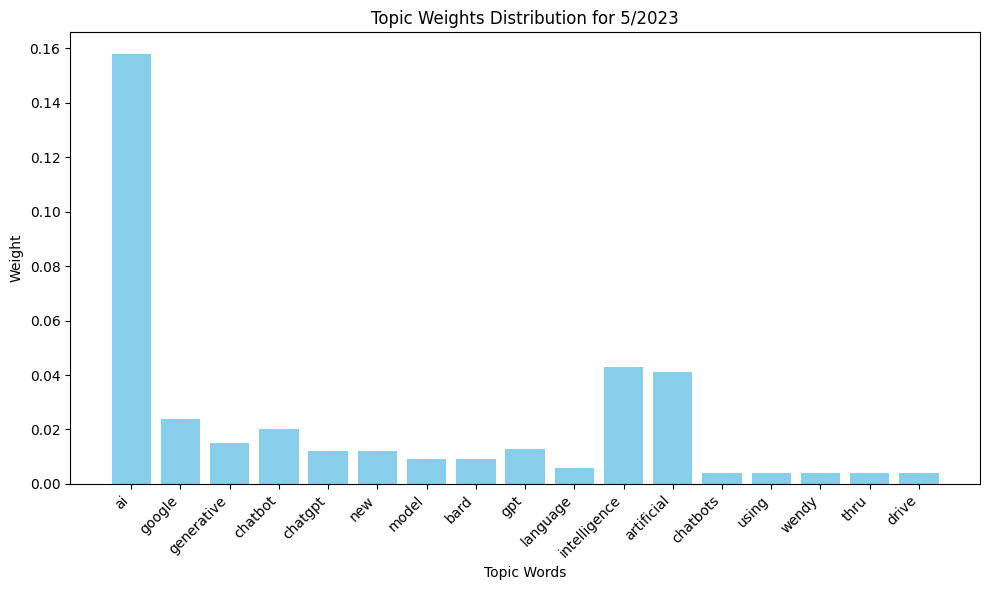

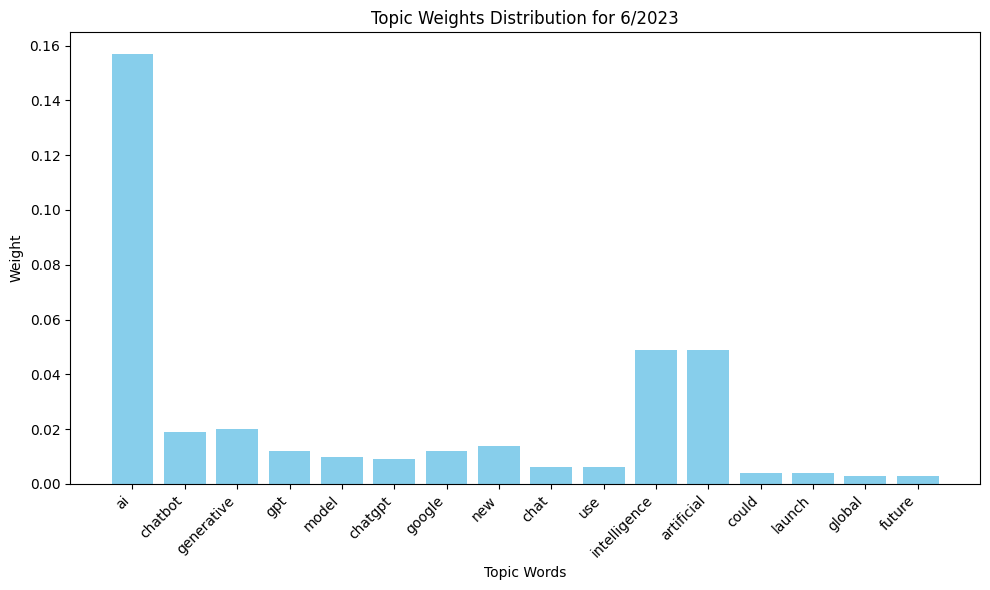

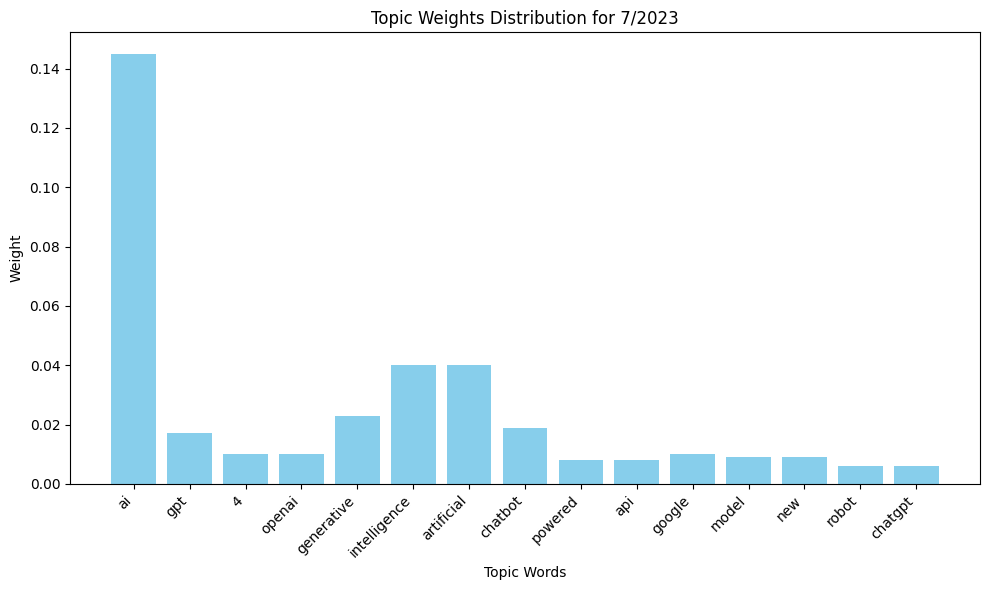

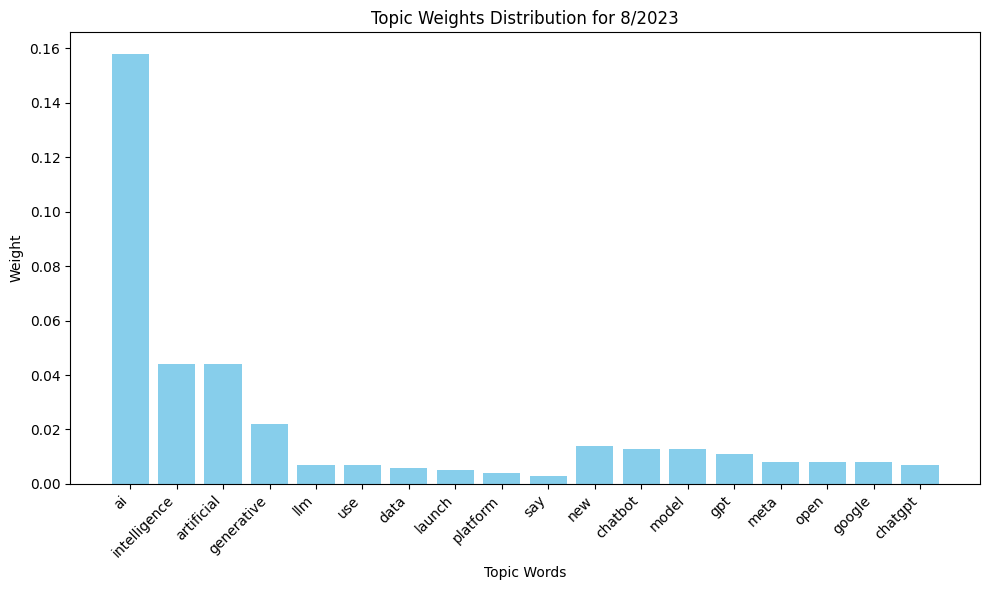

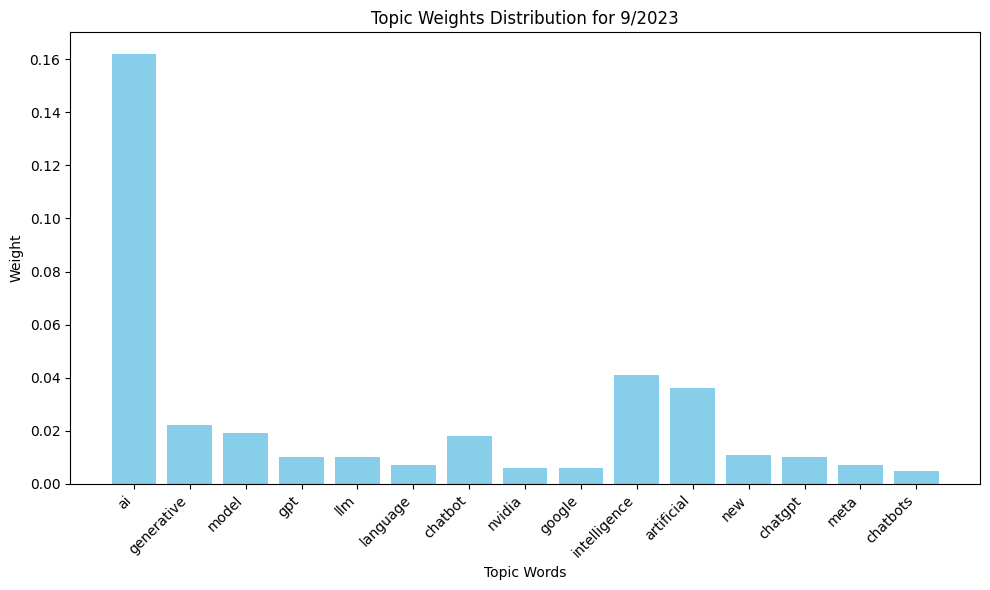

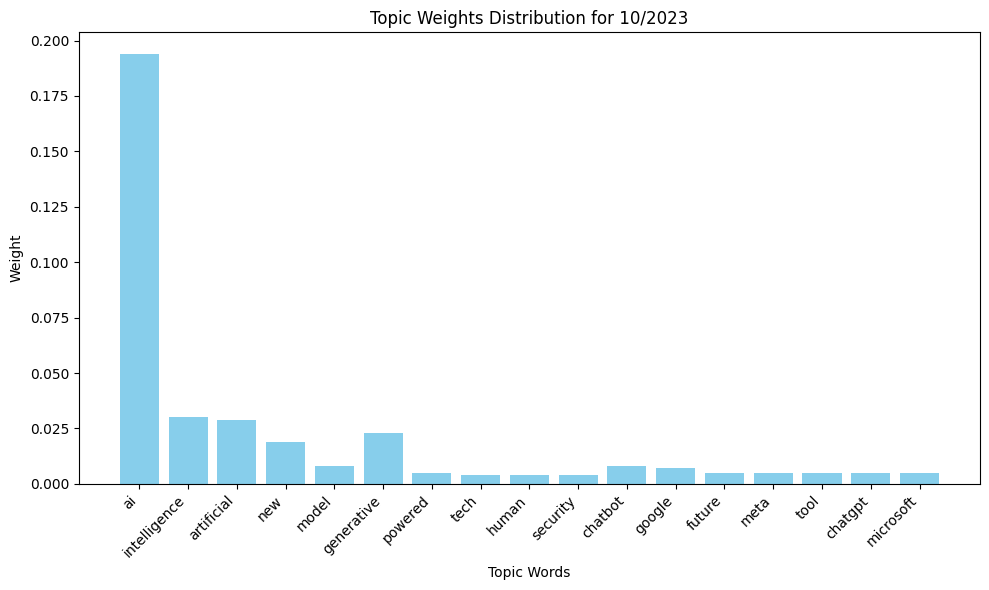

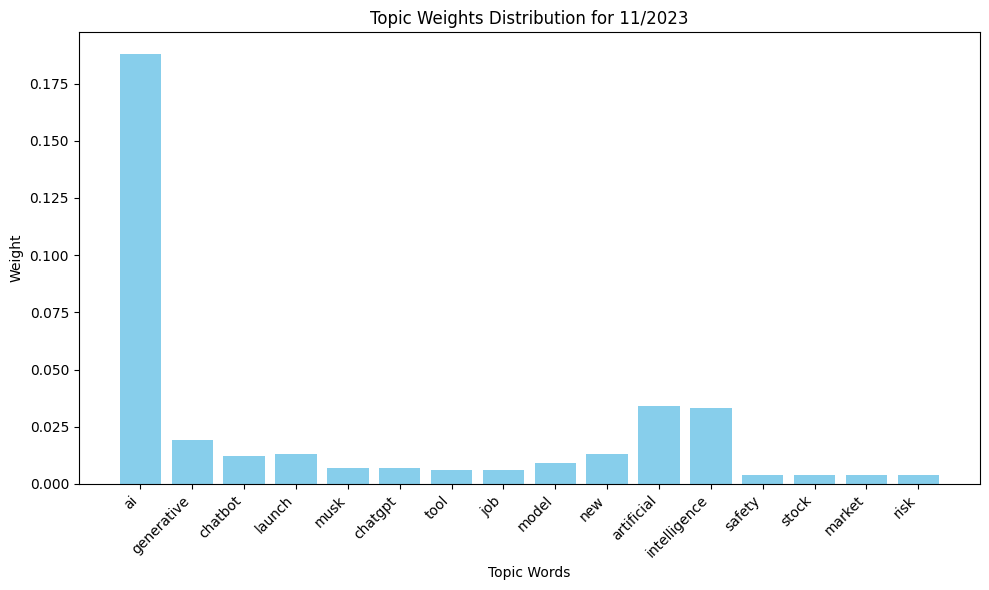

In [19]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import copy
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer() #See Appendix [2]
np.random.seed(50)

def preprocess(text):

      tokens = word_tokenize(text.lower())
      tokens = [token for token in tokens if token.isalnum()]
      tokens = [token for token in tokens if token not in stop_words]
      tokens = [lemmatizer.lemmatize(token) for token in tokens]
      return tokens

def getWordsWeights(month):

  allTokens = df[df['monthYear'] == month]['translated_title'].apply(preprocess)
  dictionary = Dictionary(allTokens)
  corpus = [dictionary.doc2bow(tokens) for tokens in allTokens]

  lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=2, passes=10, random_state=50) #See Appendix [3]

  topics = {}
  for topic_id, topic in lda_model.print_topics():
      words = topic.split("+")
      for wordWeight in words:
        weight, word = wordWeight.strip(" ").split("*")
        word = word[1:-1]
        if word in topics:
          topics[word] += float(weight)
        else:
          topics[word] = float(weight)

  return topics, lda_model, corpus

allWords = set()
octWords = []

for month in dates:
  topics, lda_model, corpus = getWordsWeights(month)

  words = list(topics.keys())
  if month == "10/2023": #need october's model for later
    lda_model_saved = copy.deepcopy(lda_model)
    corpus_saved = copy.deepcopy(corpus)
    topics_saved = copy.deepcopy(topics)
    for word in words:
      octWords.append(word)

  else:
    for word in words:
      allWords.add(word)

  weights = list(topics.values())

  plt.figure(figsize=(10, 6))
  plt.bar(words, weights, color='skyblue')
  plt.xlabel('Topic Words')
  plt.ylabel('Weight')
  plt.title('Topic Weights Distribution for {x}'.format(x=month))
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show

print("Words that were present in October that were not present in other months:")
exclusiveOctWords = [x for x in octWords if x not in allWords]
for word in exclusiveOctWords:
  print(word+":" ,topics_saved[word])




In [20]:
topic_dict = {i: [] for i in range(2)} #only 2 topics found in previous function

for docID in range(len(corpus_saved)):
    topic_arr = lda_model_saved[corpus_saved[docID]]
    for topicID, prob in topic_arr:
        topic_dict[topicID].append((docID, prob))


for topicID, probs in topic_dict.items():
    title_probs = sorted(probs, key = lambda x: x[1], reverse = True) #sorts by x[1] which is the probability/weight
    index_top_20 = [x[0] for x in title_probs[:20]]

octDf = df[df['monthYear'] == "10/2023"]['translated_title']

for index in index_top_20:
  title = octDf[index+2991]
  print(title)


Meta integrates generative AI into Instagram 
Balancing Artificial Intelligence And Intellectual Property: Human   
The Amazing Ways Chinese Tech Giant Alibaba Uses Generative Artificial Intelligence 
Weaviate AI Native Vector Database Now Available in Google   
It's not Kendall Jenner! This is Billie, an Artificial Intelligence chatbot 
The Elias project: Artificial Intelligence research for sustainable   
This AI Paper Unveils OpenBA: An Open Sourced 15B Parameter Bilingual Model Outperforming Predecessors and Aiding Chinese centric NLP Advancements 
What Dallas Fort Worth’s transportation future holds with AI 
10 AI Cybersecurity Threats You Should Be Aware Of 
Why use generative AI?  Reduce employee errors and speed up work 
"MS unveils its own AI chip 'Athena' in November"  Reduces dependence on GPU 
Lawyers win in race to generative AI without adequate laws 
Amazon clearly did not invest in this AI by chance 
The True Value of Gen AI for Quality Engineering 
What AI features are 

#Appendix:

Note: All queries were entered into ChatGPT

[1] How can I group items by datetime in a dataframe? Can I use "resample" instead of "groupby"?

[2] How do I lemmentize text for preprocessing?

[3] What is the function call with parameters for the LdaModel function?

[4] How to put text on a matplotlib plot.

[5] How do I find Point-biserial correlation coefficient in Python?

[6] How do I do a Barlett test in Python?